In [1]:
from ecell4 import *
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from ecell4.extra import ensemble
from bisect import bisect_left    

No module named 'pint' required by 'ecell4.extra.unit'


In [2]:
def rndm(a, dt, tau, size=1):
    #http://mathworld.wolfram.com/RandomNumber.html
    r = np.random.random(size=size)
    dta, taua = dt**-a, tau**-a
    y = (taua+r*(dta-taua))**(-1./a)
    return y[0]
def takeClosest(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    return before

In [1]:
def wrap(job,job_id,task_id):
    def singlerun(run):
        phios=[0,0.5,0.3]
        phio=phios[run-1]
        print(run,phio)
        import numpy as np
        import math
        L = 5#1#3
        rv = 0.005
        Dt = 1
        phit = 0.01
        H = 3*rv*2
        dt = (2*rv)**2 / (4*Dt)
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),rv,rng)
        size=tuple(w.calculate_shape(Real3(H,L,L),rv))
        Nmv=size[1]*size[2]   
        Nt = int(phit*Nmv)
        No = int(phio*Nmv)
        #print('Nt',Nt,'No',No)
        tt = np.logspace(math.log10(dt),1,20)
        tt = np.insert(tt,0,dt)
        tt = np.insert(tt,0,0.)
        dur = tt[-1]    
        msd = np.zeros(len(tt),float)
        with species_attributes():
            O | {'D':str(0),'radius':str(rv),'location':'M'}
            T | {'D':str(Dt),'radius':str(rv),'location':'M'}
        m=get_model()
        w.bind_to(m)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        w.add_molecules(Species('O'),No)
        w.add_molecules(Species('T'),Nt)
        sim = spatiocyte.SpatiocyteSimulator(w)
        pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
        #obs = FixedIntervalTrajectoryObserver(dt,pids)
        obs = TimingTrajectoryObserver(tt,pids,True,dt)
        sim.run(dur,obs)
        data=obs.data()
        for i in range(Nt):
            msd += np.array(
                [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                     for pos in data[i]]) 
        return 
    job.update({'run':task_id})
    out=singlerun(**job)
    return

simrun=3#0
nproc=40#30
phio=0
#jobs=[{}]
#ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


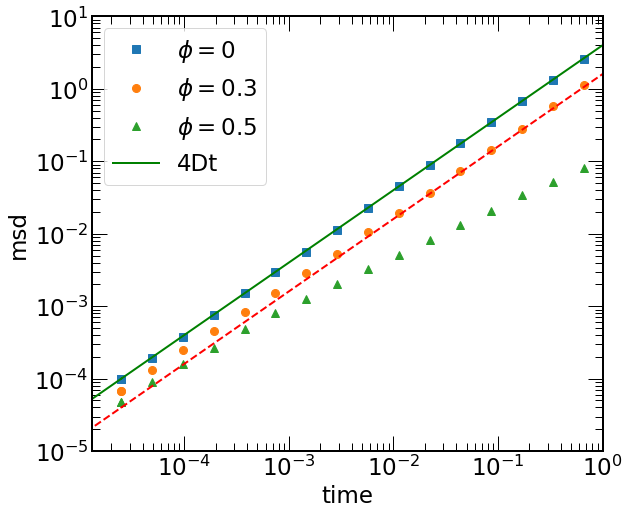

In [66]:
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=8
lw=2
mks = ['s','o','^']
for j,i in enumerate([0,0.3,0.5]):
    tt,MSD=np.loadtxt('/home/chew/outputdata/2ndpaper/MSDcrowding_phi'+str(i),delimiter=',').T
    ax.loglog(tt,MSD,marker=mks[j],linestyle='None',label='$\\phi=$'+str(i),markersize=ms)
ax.plot(tt,4*tt,'g-',linewidth=lw,label='4Dt')  #theoretical line
ax.plot(tt,0.4*4*tt,'r--',linewidth=lw)  #theoretical line
ax.set_xlim(tt[0],1)
ax.set_ylim(1e-5,10)
ax.set_xlabel("time",fontsize=fs)
ax.legend(loc='best',fontsize=fs)
ax.set_ylabel("msd",fontsize=fs)
ax.tick_params(labelsize=fs)    
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both', which='major', direction='in',length=15,width=1)
ax.tick_params(axis='both', which='minor', direction='in',length=8,width=1)
plt.savefig("/home/chew/ecellwork/figure/2ndpaper/figextra2.pdf",format='pdf',dpi=800)    